In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-08,11970.458008,11709.745117,11953.469727,11862.936523,1.833999e+10,11862.936523
2019-08-09,11915.655273,11323.898438,11861.556641,11354.024414,1.812536e+10,11354.024414
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
2019-08-12,11420.049805,10830.327148,11385.052734,10895.830078,1.668150e+10,10895.830078
...,...,...,...,...,...,...
2020-08-02,11453.079102,11012.415039,11043.768555,11246.348633,2.027171e+10,11246.348633
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438


In [ ]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,Low_Past_1,High_Past_1,Adj Close_Past_2,Volume_Past_2,Close_Past_2,Open_Past_2,Low_Past_2,High_Past_2,Adj Close_Past_3,Volume_Past_3,Close_Past_3,Open_Past_3,Low_Past_3,High_Past_3,Adj Close_Past_4,Volume_Past_4,Close_Past_4,Open_Past_4,Low_Past_4,High_Past_4,Adj Close_Past_5,Volume_Past_5,Close_Past_5,Open_Past_5,Low_Past_5,High_Past_5,Adj Close_Past_6,Volume_Past_6,Close_Past_6,Open_Past_6,...,Close_Past_24,Open_Past_24,Low_Past_24,High_Past_24,Adj Close_Past_25,Volume_Past_25,Close_Past_25,Open_Past_25,Low_Past_25,High_Past_25,Adj Close_Past_26,Volume_Past_26,Close_Past_26,Open_Past_26,Low_Past_26,High_Past_26,Adj Close_Past_27,Volume_Past_27,Close_Past_27,Open_Past_27,Low_Past_27,High_Past_27,Adj Close_Past_28,Volume_Past_28,Close_Past_28,Open_Past_28,Low_Past_28,High_Past_28,Adj Close_Past_29,Volume_Past_29,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-08,10450.311523,10144.929688,10443.228516,10334.974609,1.759594e+10,10334.974609,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,10292.3,10898.8,10575.5,1.45512e+10,10575.5,10588.2,10516.4,10627.3,10594.5,1.67427e+10,10594.5,10621.2,10434.7,10762.6,10623.5,1.93849e+10,10623.5,10345.7,...,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6,11354,1.81254e+10,11354,11861.6,11323.9,11915.7
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,10292.3,10898.8,10575.5,1.45512e+10,10575.5,10588.2,10516.4,10627.3,10594.5,1.67427e+10,10594.5,10621.2,...,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,10292.3,10898.8,10575.5,1.45512e+10,10575.5,10588.2,...,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,...,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,1089

In [ ]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,Low_Past_1,High_Past_1,Adj Close_Past_2,Volume_Past_2,Close_Past_2,Open_Past_2,Low_Past_2,High_Past_2,Adj Close_Past_3,Volume_Past_3,Close_Past_3,Open_Past_3,Low_Past_3,High_Past_3,Adj Close_Past_4,Volume_Past_4,Close_Past_4,Open_Past_4,Low_Past_4,High_Past_4,Adj Close_Past_5,Volume_Past_5,Close_Past_5,Open_Past_5,Low_Past_5,High_Past_5,Adj Close_Past_6,Volume_Past_6,Close_Past_6,Open_Past_6,...,Open_Past_24,Low_Past_24,High_Past_24,Adj Close_Past_25,Volume_Past_25,Close_Past_25,Open_Past_25,Low_Past_25,High_Past_25,Adj Close_Past_26,Volume_Past_26,Close_Past_26,Open_Past_26,Low_Past_26,High_Past_26,Adj Close_Past_27,Volume_Past_27,Close_Past_27,Open_Past_27,Low_Past_27,High_Past_27,Adj Close_Past_28,Volume_Past_28,Close_Past_28,Open_Past_28,Low_Past_28,High_Past_28,Adj Close_Past_29,Volume_Past_29,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-09,10394.353516,10020.573242,10336.408203,10115.975586,1.490681e+10,10115.975586,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,10292.3,10898.8,10575.5,1.45512e+10,10575.5,10588.2,10516.4,10627.3,10594.5,1.67427e+10,10594.5,10621.2,...,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,11523.6,1.57744e+10,11523.6,11349.7,11248.3,11523.6,DOWN
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,10292.3,10898.8,10575.5,1.45512e+10,10575.5,10588.2,...,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2,DOWN
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,10348.9,10558.7,10353.3,1.95366e+10,10353.3,10578.2,...,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,UP
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,10099.2,10442.3,10178.4,1.54281e+10,10178.4,10123,9980.78,10215.9,10116,1.49068e+10,10116,10336.4,10020.6,10394.4,10335,1.75959e+10,10335,10443.2,10144.9,10450.3,10441.3,1.36706e+10,10441.3,10518.1,10409.1,10595.6,10517.3,1.53074e+10,10517.3,10353.9,...,10916.3,10619,10947,10916.1,1.60383e+10,10916.1,10350.3,10313.2,10916.1,10345.8,1.29998e+10,10345.8,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,UP
20

In [ ]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-09,10115.975586,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,11382.6,11523.6,10336.408203,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,11349.7,DOWN
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,11382.6,10123.035156,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,10176.819336,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10415.362305,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10345.403320,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,11053.614258,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,9159.04,9151.39,9132.23,9192.84,9243.21,9243.61,9276.5,9240.35,9278.81,9277.97,9428.33,9252.28,9375.47,9073.94,9132.49,9087.3,11758.764648,11322.6,11110.2,11099.8,10913,11017.5,9905.22,968

In [57]:
# load pre-fetched news sentiment data and add in the dataframe
import pickle
import warnings
warnings.filterwarnings('ignore')
f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,Close_Past_10,Close_Past_11,Close_Past_12,Close_Past_13,Close_Past_14,Close_Past_15,Close_Past_16,Close_Past_17,Close_Past_18,Close_Past_19,Close_Past_20,Close_Past_21,Close_Past_22,Close_Past_23,Close_Past_24,Close_Past_25,Close_Past_26,Close_Past_27,Close_Past_28,Close_Past_29,Close_Past_30,Open,Open_Past_1,Open_Past_2,Open_Past_3,Open_Past_4,Open_Past_5,Open_Past_6,Open_Past_7,Open_Past_8,Open_Past_9,Open_Past_10,Open_Past_11,Open_Past_12,Open_Past_13,Open_Past_14,Open_Past_15,Open_Past_16,Open_Past_17,Open_Past_18,Open_Past_19,Open_Past_20,Open_Past_21,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-09,10115.975586,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,11382.6,11523.6,10336.408203,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,11349.7,DOWN,0.0317333,0.850567,0.1177
2019-09-10,10178.372070,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,11382.6,10123.035156,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,11528.2,DOWN,0.0490984,0.869071,0.0818306
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10895.8,10176.819336,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP,0.0484984,0.888504,0.0629979
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10051.7,10415.362305,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP,0.0588,0.8413,0.0999
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,10346.8,9757.97,9630.66,9598.17,9510.2,9754.42,10185.5,10370.8,10138.5,10160,10408,10131.1,10138,10763.2,10916.1,10345.8,10231.7,10374.3,10311.5,10345.403320,10415.4,10176.8,10123,10336.4,10443.2,10518.1,10353.9,10578.2,10588.2,10621.2,10345.7,9757.47,9630.59,9597.54,9514.84,9756.79,10203.4,10372.8,10126.3,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN,0.0439319,0.879837,0.0762308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,11053.614258,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,9905.17,9677.11,9536.89,9581.07,9525.36,9374.89,9164.23,9185.82,9159.04,9151.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
Y = btc['MonthTrend']
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)

In [59]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
print(grid.best_params_)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done 3538 tasks      | elapsed:   11.2s


{'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_split': 4, 'splitter': 'random'}


[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:   16.6s finished


In [60]:
# error rate
model_tree = OneVsRestClassifier(DecisionTreeClassifier(criterion='gini',min_samples_split=2,splitter="best",max_features="auto",
                                    max_leaf_nodes=10,max_depth=6))
model_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

0.41000000000000003

In [61]:
model_tree.score(X_train, Y_train)

0.7445887445887446

In [62]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,multilabel_confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, prediction))

[[[23 31]
  [10 36]]

 [[36 10]
  [31 23]]]


In [63]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

        DOWN       0.54      0.78      0.64        46
          UP       0.70      0.43      0.53        54

    accuracy                           0.59       100
   macro avg       0.62      0.60      0.58       100
weighted avg       0.62      0.59      0.58       100



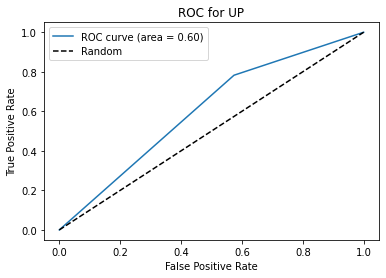

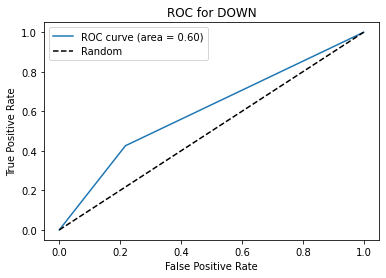

In [64]:
 # Plot the ROC curve

def plot_roc(Y_test,Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 2
    Y_test_dummies = pd.get_dummies(Y_test, drop_first=False).values
    Y_pred_dummies = pd.get_dummies(Y_pred,drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_dummies[:, i],Y_pred_dummies[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    title = ["ROC for UP", "ROC for DOWN"]
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--', label="Random")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title[i])
        plt.legend(loc="best")
        plt.show()
plot_roc(Y_test,prediction)

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50,None]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="accuracy", cv=10, verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
print(random_grid.best_params_)

In [66]:
model_random_tree = OneVsRestClassifier(RandomForestClassifier(criterion= 'gini',min_samples_split=2,max_features="auto",
                                    max_leaf_nodes=10,max_depth=6,min_samples_leaf=6))
model_random_tree.fit(X_train,Y_train)
tree_error_rate = 1 - model_random_tree.score(X_test,Y_test)
tree_error_rate

0.47

In [67]:
model_random_tree.score(X_train, Y_train)

0.8831168831168831

In [68]:
new_prediction = model_random_tree.predict(X_test)
print(multilabel_confusion_matrix(Y_test, new_prediction))

[[[29 25]
  [22 24]]

 [[24 22]
  [25 29]]]


In [69]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

        DOWN       0.49      0.52      0.51        46
          UP       0.57      0.54      0.55        54

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100



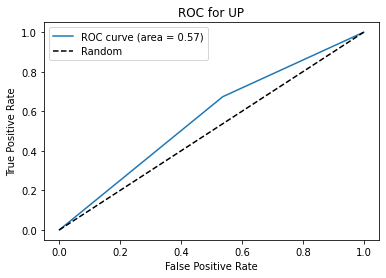

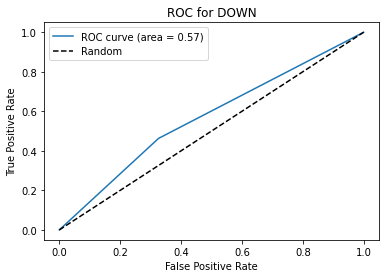

In [77]:
plot_roc(Y_test,new_prediction)

test error: 0.41000000000000003
[[[30 24]
  [17 29]]

 [[29 17]
  [24 30]]]


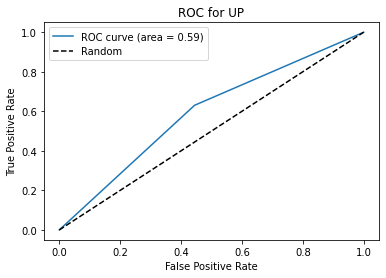

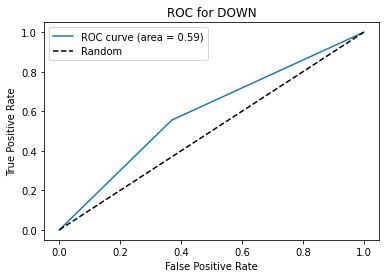

In [113]:
# for model after adding news sentiment
clf = RandomForestClassifier(criterion= 'gini', min_samples_split=10, max_features='auto', max_depth=10, random_state=0)
clf.fit(X_train, Y_train)
print('test error:', 1 - clf.score(X_test, Y_test))

new_prediction = clf.predict(X_test)
print(multilabel_confusion_matrix(Y_test, new_prediction))

plot_roc(Y_test,new_prediction)